<a href="https://colab.research.google.com/github/ChicagoDataScientist/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [36]:
# Get a better understanding of the dataframe

df.shape

(3151, 21)

In [37]:
# Get a better understanding of the dataframe

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,4000.0,2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,3500.0,2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,4000.0,2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,1710.0,1872.0,1940.0,1,A5,620000,2019-01-02


In [0]:
# Create data subset

df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df = df[df['SALE_PRICE'] > 100000]
df = df[df['SALE_PRICE'] < 2000000]

In [8]:
# check work

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [9]:
# check work

df.shape

(3151, 21)

In [10]:
# explore data types

df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
# Remove commas from Land square feet and turn into float

df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',','').astype(float)

In [0]:
# Convert date into datetime object

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [43]:
df.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                         float64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE           

In [0]:
# Create 'month' feature

df['sale_date_month'] = df['SALE_DATE'].dt.month

In [50]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,sale_date_month
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,6800.0,1325.0,1930.0,1,A9,550000,2019-01-01,1
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,4000.0,2001.0,1940.0,1,A1,200000,2019-01-01,1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,3500.0,2043.0,1925.0,1,A1,810000,2019-01-02,1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,4000.0,2680.0,1899.0,1,A1,125000,2019-01-02,1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,1710.0,1872.0,1940.0,1,A5,620000,2019-01-02,1


In [51]:
# Create train and test data sets

train = df[df['SALE_DATE'] < '2019-03-01']
test = df[df['SALE_DATE']>= '2019-03-01']
print(train.shape, test.shape)

(1708, 22) (1443, 22)


In [0]:
train = train.drop(['SALE_DATE'], axis=1)
test = test.drop(['SALE_DATE'], axis=1)

In [0]:
# drop high cardinality items

target = 'SALE_PRICE'
high_cardinality = ['EASE-MENT','BUILDING_CLASS_CATEGORY','BLOCK','LOT','ADDRESS','APARTMENT_NUMBER','TAX_CLASS_AT_TIME_OF_SALE']
features = train.columns.drop([target] + high_cardinality)

In [110]:
# set up features and target

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
print(X_train.shape,X_test.shape)

(1708, 13) (1443, 13)


In [111]:
# encode features

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

print(X_train.shape,X_test.shape)

(1708, 44) (1443, 44)


In [0]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [120]:
# use SelectKBest to use the top features

selector = SelectKBest(score_func=f_regression,k=15)
X_train_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape


(1708, 15)

In [121]:

# see what features were selected
all_name = X_train.columns
selected_mask = selector.get_support()
selected_names = all_name[selected_mask]
unselected_names = all_name[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)
print()
print("Features Not Selected:")
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3

Features Not Selected:
BOROUGH_4
NEIGHBORHOOD_BEDFORD STUYVESANT
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SALE_A2
BUILDING_CLASS_AT_TIME_OF_SALE_S1
B

In [116]:
# That was fun, but let's look for the optimal number of features!

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $186,730 

2 features
Test Mean Absolute Error: $183,575 

3 features
Test Mean Absolute Error: $175,173 

4 features
Test Mean Absolute Error: $169,338 

5 features
Test Mean Absolute Error: $169,044 

6 features
Test Mean Absolute Error: $169,044 

7 features
Test Mean Absolute Error: $165,728 

8 features
Test Mean Absolute Error: $165,733 

9 features
Test Mean Absolute Error: $163,058 

10 features
Test Mean Absolute Error: $162,703 

11 features
Test Mean Absolute Error: $162,418 

12 features
Test Mean Absolute Error: $162,086 

13 features
Test Mean Absolute Error: $161,377 

14 features
Test Mean Absolute Error: $162,070 

15 features
Test Mean Absolute Error: $161,675 

16 features
Test Mean Absolute Error: $161,224 

17 features
Test Mean Absolute Error: $161,235 

18 features
Test Mean Absolute Error: $161,235 

19 features
Test Mean Absolute Error: $161,242 

20 features
Test Mean Absolute Error: $161,092 

21 features
Test Mean Absolut

In [0]:
#  24 Features is optimal

In [0]:

import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
%matplotlib inline

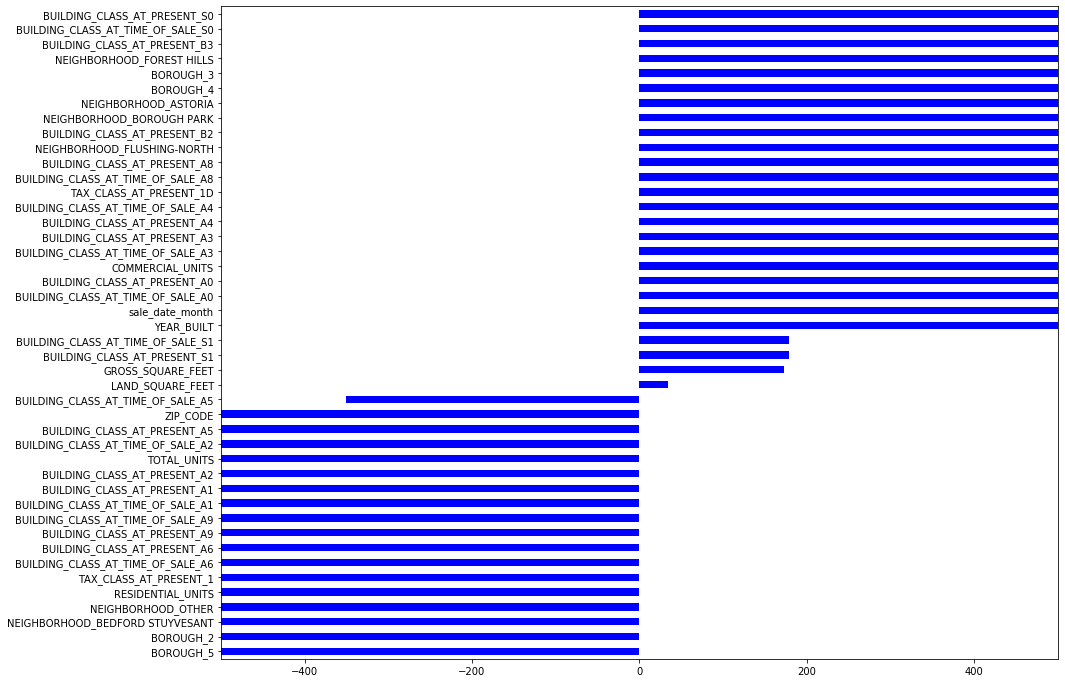

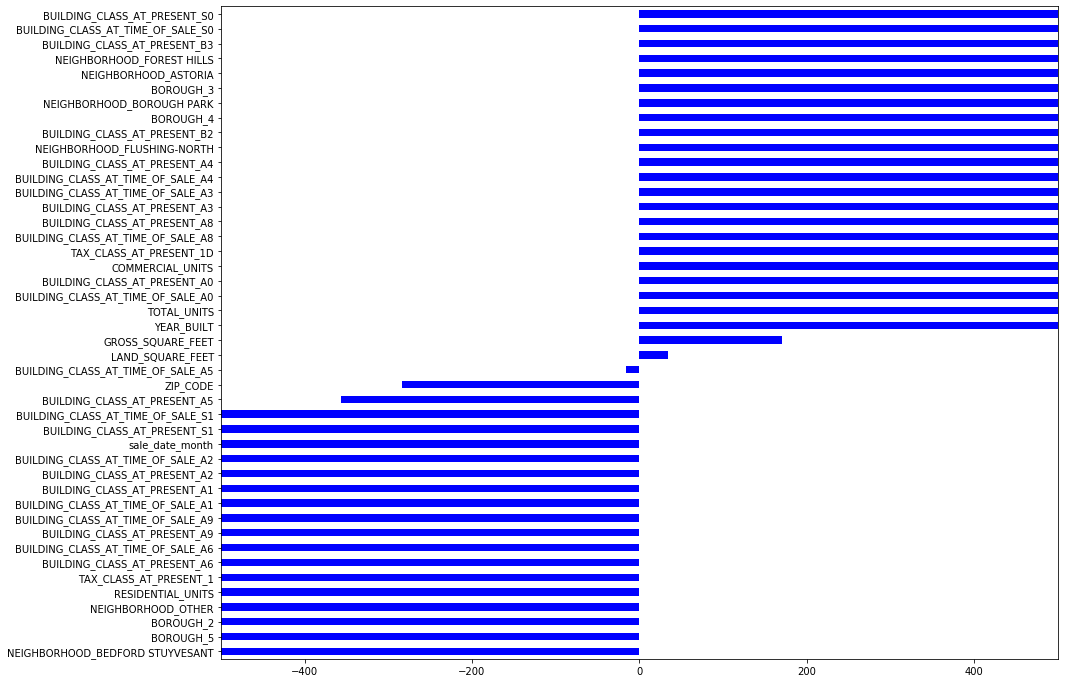

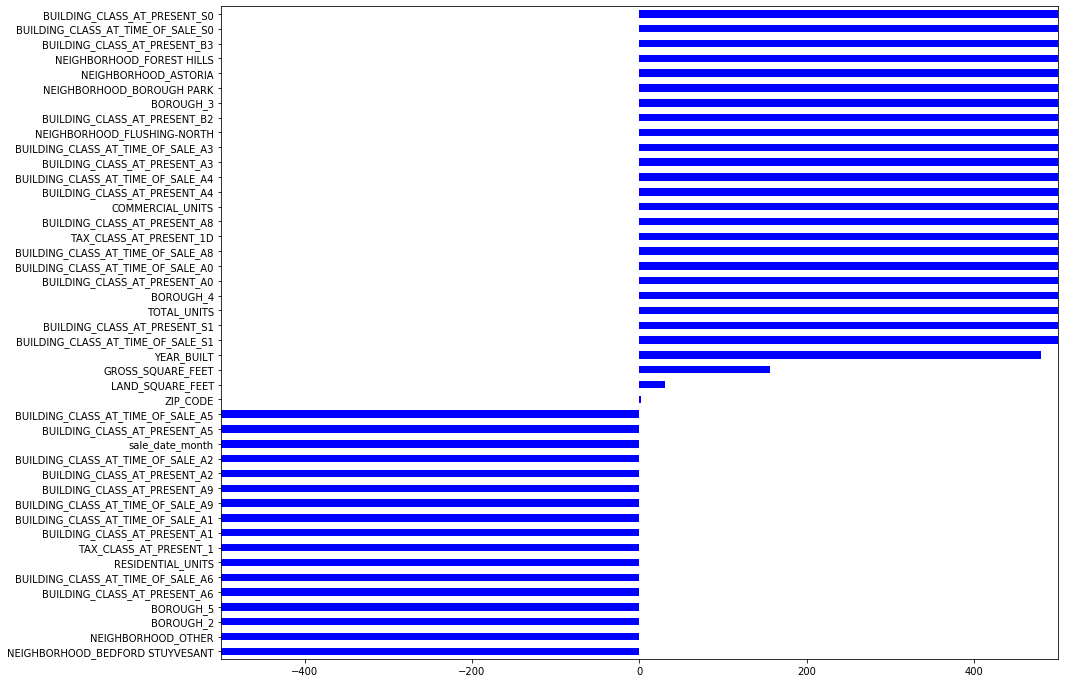

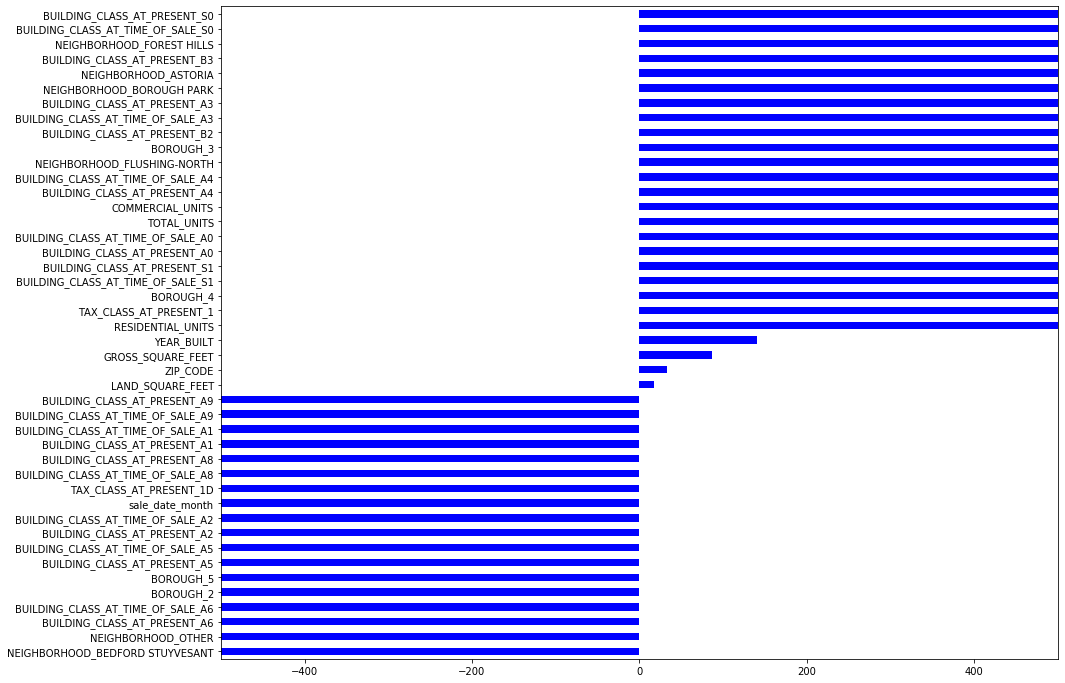

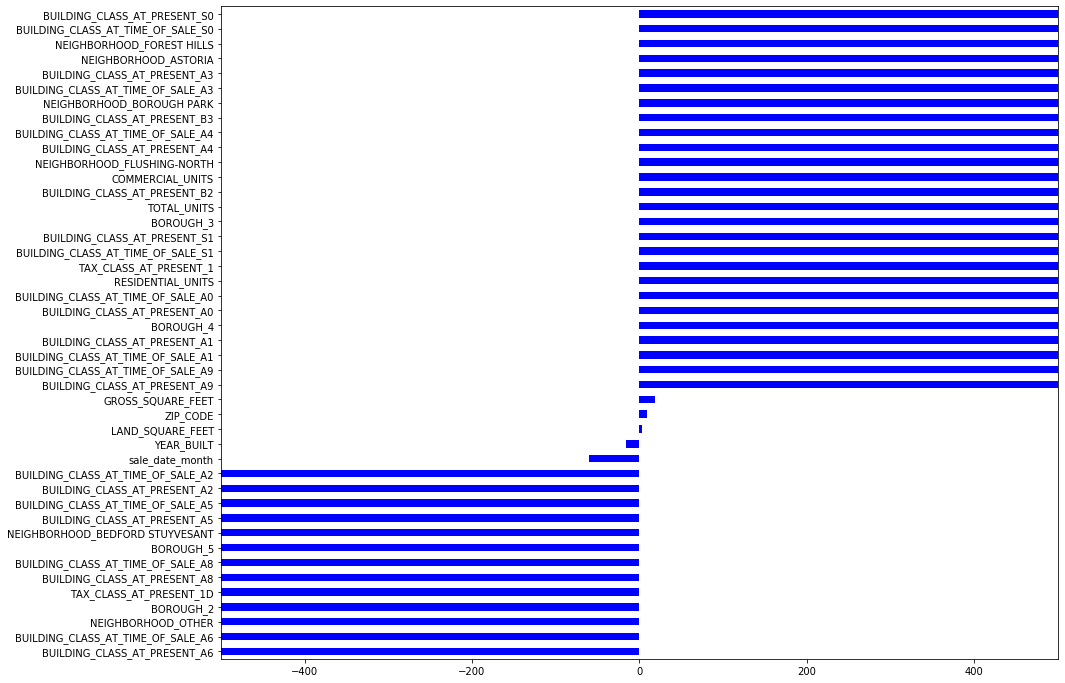

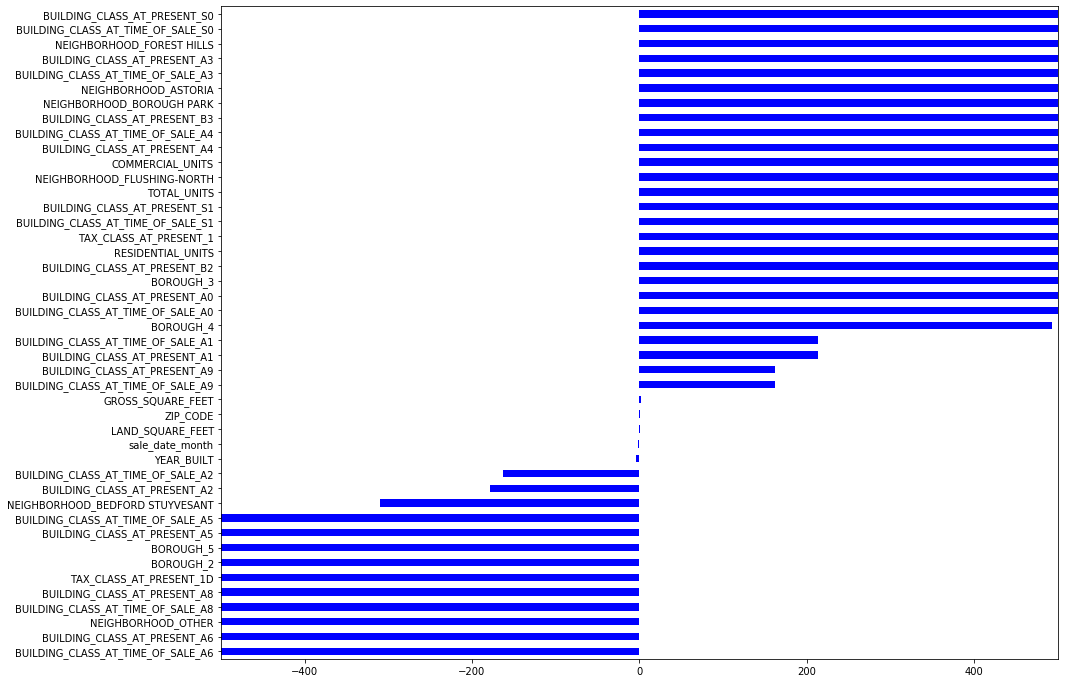

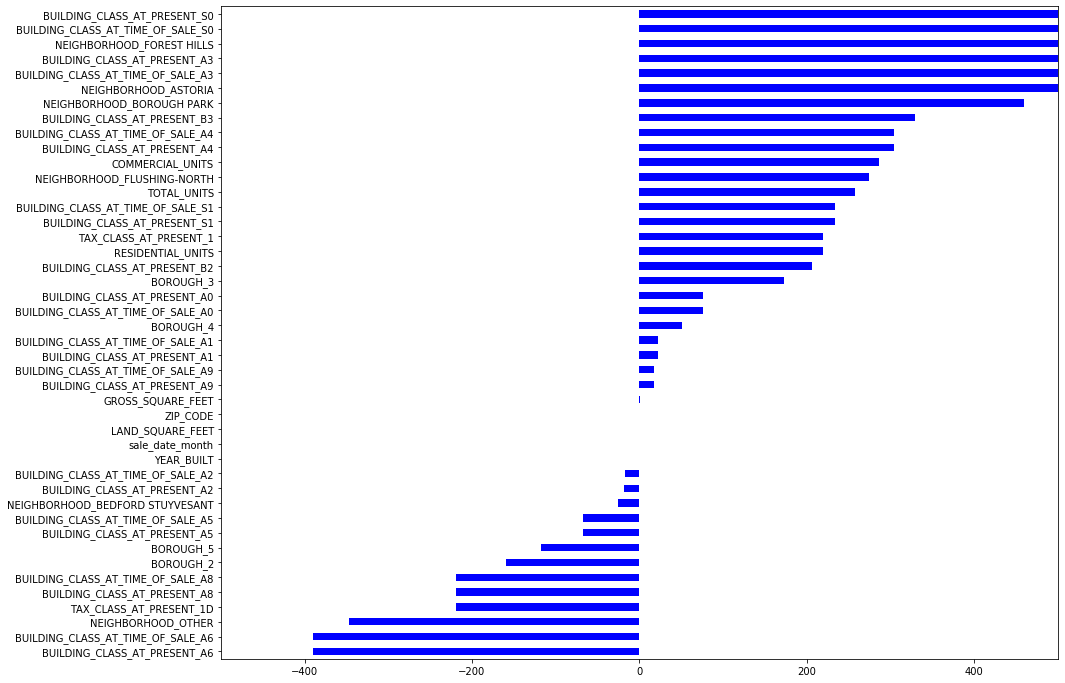

In [127]:
# Create ridge regression model

for alpha in [.001,.01,.1,1,10,100,1000]:
  display(HTML(f'RidgeRegression with alpha={alpha}'))
  model = Ridge(alpha=alpha, normalize=True)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  mae = mean_absolute_error(y_test,y_pred)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  coefficients = pd.Series(model.coef_,X_train.columns)
  plt.figure(figsize=(15,12))
  coefficients.sort_values().plot.barh(color='blue')
  plt.xlim(-500,500)
  plt.show()